In [1]:
import json
import re 
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 
from collections import Counter, defaultdict
from scipy import stats

from calibration_metric.vis.calibration_plot import plot_df
from calibration_metric.metric import ECEMetric

plt.rcParams["font.family"] = "Nimbus Roman"

from calibration_utils import (read_nucleus_file, 
                                read_gold_file,get_probs_and_accs, 
                                read_benchclamp_file, 
                                get_probs_and_accs_benchclamp,
                                get_probs_and_accs_sql,
                                get_accs_sql)

/brtx/601-nvme1/estengel/miniconda3/envs/bclamp2/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:


bart_data = read_benchclamp_file("/brtx/602-nvme1/estengel/calflow_calibration/benchclamp/logs/1.0/bart-large_spider_past_none_db_val_all_0.0001_5000_test_eval_unconstrained-beam_bs_5/model_outputs.20230208T031316.jsonl")
# bart_min_probs, bart_mean_probs, bart_accs = get_probs_and_accs_benchclamp(bart_data) 
spider_gold_path = "/brtx/601-nvme1/estengel/resources/data/benchclamp/processed/Spider/test_all.jsonl"
bart_min_probs, bart_mean_probs, bart_exact_accs = get_probs_and_accs_benchclamp(bart_data) # , spider_gold_path) 

t5_data = read_benchclamp_file("/brtx/602-nvme1/estengel/calflow_calibration/benchclamp/logs/1.0/t5-base-lm-adapt_spider_past_none_db_val_all_0.0001_10000_test_eval_unconstrained-beam_bs_5/model_outputs.20230206T093954.jsonl") 
# t5_min_probs, t5_mean_probs, t5_accs = get_probs_and_accs_benchclamp(t5_data)
t5_min_probs, t5_mean_probs, t5_exact_accs = get_probs_and_accs_benchclamp(t5_data) #, spider_gold_path)

In [3]:
bart_at_k = {}
for k in range(2, 6):
    __, __, k_bart_exact_accs = get_probs_and_accs_benchclamp(bart_data, k=k) # , spider_gold_path) 
    bart_at_k[k] = k_bart_exact_accs

In [4]:
import pdb 

def comparison_plot(min_probs, mean_probs, accs, path, use_exact_match, bclamp_data, gold_path, n_bins = 10, binning_strategy='uniform'):
    ece_metric = ECEMetric(n_bins=n_bins, binning_strategy=binning_strategy)
    if binning_strategy == "uniform":
        (min_values, 
        min_bins, 
        min_bin_number) = ece_metric.uniform_bin(min_probs, accs)
    else:
        (min_values, 
        min_bins, 
        min_bin_number) = ece_metric.adaptive_bin(min_probs, accs)

    if not use_exact_match:
        # convert exact match accuracy to evaluation accuracy
        print(f"getting sql execution accuracy for each bin")
        min_execution_accs = get_accs_sql(bclamp_data, gold_path, min_bin_number) 
        print(f"replacing exact match accuracy with execution accuracy...")
        min_values = [min_execution_accs[bin] for bin in range(len(min_values))]
        # replace the accuracies with copies of the average for computing the ECE on the eval match accuracy
        min_accs = [min_execution_accs[bin] for bin in min_bin_number]
        min_ece = ece_metric(np.array(min_probs), np.array(min_accs))
    else:
        min_ece = ece_metric(np.array(min_probs), np.array(accs))

    min_df_to_plot = ece_metric.bins_to_df(min_values, min_bins, min_bin_number)
    min_ece *= 100

    if binning_strategy == "uniform":
        (mean_values, 
        mean_bins, 
        mean_bin_number) = ece_metric.uniform_bin(mean_probs, accs)
    else:
        (mean_values, 
        mean_bins, 
        mean_bin_number) = ece_metric.adaptive_bin(mean_probs, accs)

    if not use_exact_match:
        print(f"getting sql execution accuracy for each bin")
        mean_execution_accs = get_accs_sql(bclamp_data, gold_path, mean_bin_number)
        print(f"replacing exact match accuracy with execution accuracy...")
        mean_values = [mean_execution_accs[bin] for bin in range(len(mean_values))]
        mean_accs = [mean_execution_accs[bin] for bin in mean_bin_number]
        mean_ece = ece_metric(np.array(mean_probs), np.array(mean_accs))
    else:
        mean_ece = ece_metric(np.array(mean_probs), np.array(accs))

    mean_df_to_plot = ece_metric.bins_to_df(mean_values, mean_bins, mean_bin_number)
    mean_ece *= 100

    fig, ax = plt.subplots(1,2, figsize=(5,1.8), sharex=True, sharey=True)
    metric_kwargs = {"x": 0.000, "y": 0.9, "fontsize": 10, "horizontalalignment": "left"}

    ax[0].set_title("Min. Prob.", fontsize=10)
    ax[1].set_title("Mean Prob.", fontsize=10)
    plot = plot_df(min_df_to_plot, 
                   ylabel="Model Prob.", 
                   xlabel=None, 
                   ax = ax[0], 
                   show_legend=False, 
                   metric_value=min_ece, 
                   metric_value_kwargs = metric_kwargs)
    plot = plot_df(mean_df_to_plot, 
                   ylabel="Model Prob.", 
                   xlabel=None, 
                   ax=ax[1], 
                   show_legend=True, 
                   metric_value=mean_ece, 
                   metric_value_kwargs=metric_kwargs) 
    # ax[0].set_xlabel("EM Accuracy", fontsize=10) # , bbox = {"xy": (0.7,0.0)})
    fig.text(0.5, -0.05, "Exact Match Accuracy", ha="center", va="center", fontsize=10)

    handles, labels = plt.gca().get_legend_handles_labels()
    fig.legend(handles, labels, fontsize=8, ncol=2, title="Log Count", frameon=False, bbox_to_anchor=(0.53, 0.71), handletextpad=0.1, columnspacing=0.1)

    # plt.tight_layout()
    # plt.savefig("/home/estengel/papers/did-you-mean-2022/figures/seq_calibration.pdf", bbox_inches='tight')
    if path is not None:
        plt.savefig(path, bbox_inches='tight')
    return min_values, min_bins, min_bin_number

def single_plot(min_probs, accs, path, use_exact_match, bclamp_data, gold_path, n_bins = 10, binning_strategy='uniform'):
    ece_metric = ECEMetric(n_bins=n_bins, binning_strategy=binning_strategy)
    if binning_strategy == "uniform":
        (min_values, 
        min_bins, 
        min_bin_number) = ece_metric.uniform_bin(min_probs, accs)
    else:
        (min_values, 
        min_bins, 
        min_bin_number) = ece_metric.adaptive_bin(min_probs, accs)

    if not use_exact_match:
        # convert exact match accuracy to evaluation accuracy
        print(f"getting sql execution accuracy for each bin")
        min_execution_accs = get_accs_sql(bclamp_data, gold_path, min_bin_number) 
        print(f"replacing exact match accuracy with execution accuracy...")
        min_values_before = min_values.copy()
        min_values = [min_execution_accs[bin] for bin in range(len(min_values))]
        for before, after in zip(min_values_before, min_values):
            assert(before <= after)
            print(f"{before:.3f} -> {after:.3f}")
        # replace the accuracies with copies of the average for computing the ECE on the eval match accuracy
        min_accs = [min_execution_accs[bin] for bin in min_bin_number]
        min_ece = ece_metric(np.array(min_probs), np.array(min_accs))
    else:
        min_ece = ece_metric(np.array(min_probs), np.array(accs))

    min_df_to_plot = ece_metric.bins_to_df(min_values, min_bins, min_bin_number)
    min_ece *= 100

    fig, ax = plt.subplots(1,1, figsize=(5,1.8), sharex=True, sharey=True)
    metric_kwargs = {"x": 0.000, "y": 0.9, "fontsize": 10, "horizontalalignment": "left"}

    ax.set_title("Min. Prob.", fontsize=10)
    ax.set_title("Mean Prob.", fontsize=10)
    plot = plot_df(min_df_to_plot, 
                   ylabel="Model Prob.", 
                   xlabel=None, 
                   ax = ax, 
                   show_legend=False, 
                   metric_value=min_ece, 
                   metric_value_kwargs = metric_kwargs)
    if use_exact_match:
        ax.set_xlabel("EM Accuracy", fontsize=10) # , bbox = {"xy": (0.7,0.0)})
    else:
        ax.set_xlabel("Eval Accuracy", fontsize=10) # , bbox = {"xy": (0.7,0.0)})

    handles, labels = plt.gca().get_legend_handles_labels()
    # fig.legend(handles, labels, fontsize=8, ncol=2, title="Log Count", frameon=False, bbox_to_anchor=(0.53, 0.71), handletextpad=0.1, columnspacing=0.1)

    if path is not None:
        plt.savefig(path, bbox_inches='tight')
    return min_values, min_bins, min_bin_number



In [5]:
def horizontal_plot(min_probs, accs, path, bclamp_data, gold_path, n_bins = 10, binning_strategy='uniform', title=None):
    ece_metric = ECEMetric(n_bins=n_bins, binning_strategy=binning_strategy)
    if binning_strategy == "uniform":
        (min_values_em, 
        min_bins, 
        min_bin_number) = ece_metric.uniform_bin(min_probs, accs)
    else:
        (min_values_em, 
        min_bins, 
        min_bin_number) = ece_metric.adaptive_bin(min_probs, accs)

    # convert exact match accuracy to evaluation accuracy
    print(f"getting sql execution accuracy for each bin")
    min_execution_accs = get_accs_sql(bclamp_data, gold_path, min_bin_number) 
    print(f"replacing exact match accuracy with execution accuracy...")
    min_values_ev = [min_execution_accs[bin] for bin in range(len(min_values_em))]
    lines_to_plot = []
    for before_x, before_y, after_x in zip(min_values_em, min_bins, min_values_ev):
        # assert(before_x <= after_x)
        print(f"{before_x:.3f} -> {after_x:.3f}")
        lines_to_plot.append(((before_x, before_y), (after_x, before_y)))
    # replace the accuracies with copies of the average for computing the ECE on the eval match accuracy

    min_df_to_plot_em = ece_metric.bins_to_df(min_values_em, min_bins, min_bin_number)
    min_df_to_plot_ev = ece_metric.bins_to_df(min_values_ev, min_bins, min_bin_number)

    fig, ax = plt.subplots(1,1, figsize=(4.5,4.5), sharex=True, sharey=True)
    metric_kwargs = {"x": 0.000, "y": 0.9, "fontsize": 10, "horizontalalignment": "left"}

    ax.set_title("Min. Prob.", fontsize=10)
    ax.set_title("Mean Prob.", fontsize=10)
    plot = plot_df(min_df_to_plot_em, 
                   ylabel="Model Prob.", 
                   xlabel=None, 
                   ax = ax, 
                   show_legend=False)
    # overlay onto same plot
    plot = plot_df(min_df_to_plot_ev, 
                   ylabel="Model Prob.", 
                   xlabel=None, 
                   ax = ax, 
                   show_legend=False)
    ax.set_xlabel("Accuracy", fontsize=10) # , bbox = {"xy": (0.7,0.0)})

    # plot connecting lines
    for line in lines_to_plot:
        (x1, y1), (x2, y2) = line
        ax.plot([x1, x2], [y1, y2], color='black', linewidth=0.5, linestyle='--')

    # handles, labels = plt.gca().get_legend_handles_labels()
    # fig.legend(handles, labels, fontsize=8, ncol=2, title="Log Count", frameon=False, bbox_to_anchor=(0.53, 0.71), handletextpad=0.1, columnspacing=0.1)
    if title is not None:
        ax.set_title(title, fontsize=14)

    if path is not None:
        plt.savefig(path, bbox_inches='tight')
    # return min_values, min_bins, min_bin_number


In [6]:
def horizontal_plot_at_k(min_probs, accs_at_k, path, bclamp_data, gold_path, n_bins = 10, binning_strategy='uniform', title=None):
    fig, ax = plt.subplots(1,1, figsize=(4.5,4.5), sharex=True, sharey=True)

    ece_metric = ECEMetric(n_bins=n_bins, binning_strategy=binning_strategy)
    bins_vals_at_k = {}
    for k in accs_at_k.keys():
        if binning_strategy == "uniform":
            (min_values_em, 
            min_bins, 
            min_bin_number) = ece_metric.uniform_bin(min_probs, accs_at_k[k])
        else:
            (min_values_em, 
            min_bins, 
            min_bin_number) = ece_metric.adaptive_bin(min_probs, accs_at_k[k])
        bins_vals_at_k[k] = (min_values_em, min_bins, min_bin_number)

        if k == 1: 
            # convert exact match accuracy to evaluation accuracy
            print(f"getting sql execution accuracy for each bin")
            min_execution_accs = get_accs_sql(bclamp_data, gold_path, min_bin_number, min_bins) 
            print(f"replacing exact match accuracy with execution accuracy...")
            min_values_ev = [min_execution_accs[bin] for bin in range(len(min_values_em))]
            lines_to_plot = []
            for before_x, before_y, after_x in zip(min_values_em, min_bins, min_values_ev):
                # assert(before_x <= after_x)
                print(f"{before_x:.3f} -> {after_x:.3f}")
                lines_to_plot.append(((before_x, before_y), (after_x, before_y)))
            # replace the accuracies with copies of the average for computing the ECE on the eval match accuracy
            min_df_to_plot_ev = ece_metric.bins_to_df(min_values_ev, min_bins, min_bin_number)
            # overlay onto same plot
            plot = plot_df(min_df_to_plot_ev, 
                        ylabel="Model Prob.", 
                        xlabel=None, 
                        ax = ax, 
                        show_legend=False)

        min_df_to_plot_em = ece_metric.bins_to_df(min_values_em, min_bins, min_bin_number)

        metric_kwargs = {"x": 0.000, "y": 0.9, "fontsize": 10, "horizontalalignment": "left"}

        ax.set_title("Min. Prob.", fontsize=10)
        ax.set_title("Mean Prob.", fontsize=10)
        plot = plot_df(min_df_to_plot_em, 
                    ylabel="Model Prob.", 
                    xlabel=None, 
                    ax = ax, 
                    show_legend=False)
    ax.set_xlabel("Accuracy", fontsize=10) # , bbox = {"xy": (0.7,0.0)})

    # plot connecting lines
    for line in lines_to_plot:
        (x1, y1), (x2, y2) = line
        ax.plot([x1, x2], [y1, y2], color='black', linewidth=0.5, linestyle='--')

    # handles, labels = plt.gca().get_legend_handles_labels()
    # fig.legend(handles, labels, fontsize=8, ncol=2, title="Log Count", frameon=False, bbox_to_anchor=(0.53, 0.71), handletextpad=0.1, columnspacing=0.1)
    if title is not None:
        ax.set_title(title, fontsize=14)

    if path is not None:
        plt.savefig(path, bbox_inches='tight')
    # return min_values, min_bins, min_bin_number


getting sql execution accuracy for each bin
Bin number: 0 with confidence 0.7829297644731674
command: python3 evaluation.py --gold /brtx/602-nvme1/estengel/calflow_calibration/benchclamp/logs/1.0/analysis_spider_0/gold.txt --pred /brtx/602-nvme1/estengel/calflow_calibration/benchclamp/logs/1.0/analysis_spider_0/pred.txt --db /brtx/601-nvme1/estengel/resources/data/benchclamp/raw/test_sql/database --table /brtx/601-nvme1/estengel/resources/data/benchclamp/raw/Spider/tables.json --etype all
stdout: medium pred: SELECT max ( capacity ) , avg ( capacity ) FROM stadium
medium gold: SELECT max ( capacity ) , average FROM stadium

medium pred: SELECT T2.name , count ( * ) FROM performance AS T1 JOIN stadium AS T2 ON T1.stadium_id = T2.stadium_id GROUP BY T1.stadium_id
medium gold: SELECT T2.name , count ( * ) FROM concert AS T1 JOIN stadium AS T2 ON T1.stadium_id = T2.stadium_id GROUP BY T1.stadium_id

medium pred: SELECT T3.concert_name , T3.theme , count ( * ) FROM singers_in_concert AS T1 

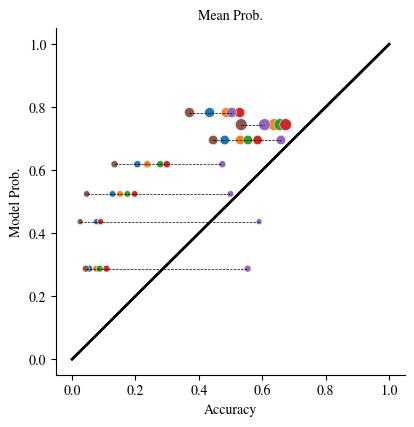

In [7]:
# horizontal_plot(bart_min_probs, 
#                 bart_exact_accs, 
#                 None, 
#                 bclamp_data=bart_data,
#                 gold_path=spider_gold_path,
#                 n_bins=10, 
#                 title="Acc@1",
#                 binning_strategy='adaptive')

bart_at_k[1] = bart_exact_accs
# for k in range(2, 6):
horizontal_plot_at_k(bart_min_probs, 
                bart_at_k, 
                None, 
                bclamp_data=bart_data,
                gold_path=spider_gold_path,
                n_bins=10, 
                # title=f"Acc@{k}",
                binning_strategy='adaptive')

getting sql execution accuracy for each bin
replacing exact match accuracy with execution accuracy...
0.370 -> 0.503
0.534 -> 0.607
0.445 -> 0.659
0.134 -> 0.474
0.047 -> 0.500
0.026 -> 0.590
0.043 -> 0.554


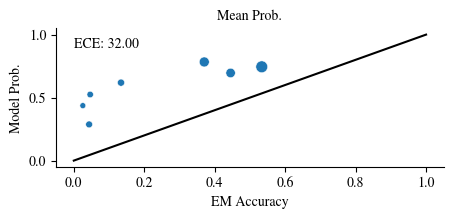

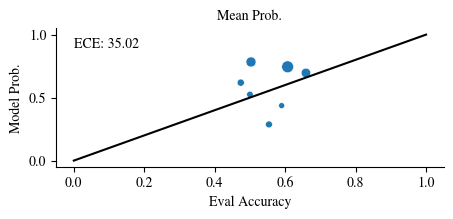

In [13]:
exact_bart_values, exact_bart_bins, exact_bart_bin_number = single_plot(bart_min_probs, 
                                                          bart_exact_accs, 
                                                          None, 
                                                          use_exact_match=True,
                                                          bclamp_data=bart_data,
                                                          gold_path=spider_gold_path,
                                                          n_bins=10, 
                                                          binning_strategy='adaptive')

eval_bart_values, eval_bart_bins, eval_bart_bin_number = single_plot(bart_min_probs, 
                                                          bart_exact_accs, 
                                                          None, 
                                                          use_exact_match=False,
                                                          bclamp_data=bart_data,
                                                          gold_path=spider_gold_path,
                                                          n_bins=10, 
                                                          binning_strategy='adaptive')

/home/estengel/calibration_metric/calibration_metric/utils/warnings.py:12: RuntimeWarning: Metric Weighted ECE has less than 3 active bins
  warnings.warn(f"Metric {metric_name} has less than 3 active bins", RuntimeWarning)


getting sql execution accuracy for each bin
replacing exact match accuracy with execution accuracy...
getting sql execution accuracy for each bin
replacing exact match accuracy with execution accuracy...


/home/estengel/calibration_metric/calibration_metric/utils/warnings.py:12: RuntimeWarning: Metric Weighted ECE has less than 3 active bins
  warnings.warn(f"Metric {metric_name} has less than 3 active bins", RuntimeWarning)


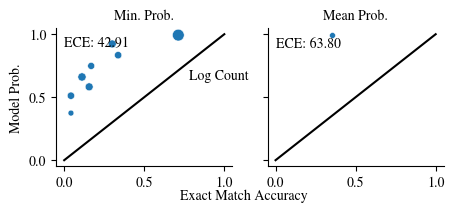

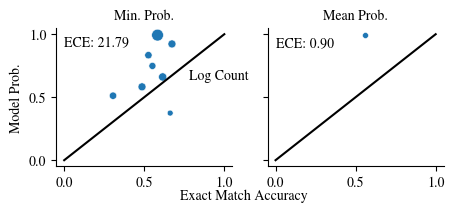

In [6]:

# TODO (elias): how can the execution accuracy be lower than the exact match accuracy?
t5_values, t5_bins, t5_bin_number = comparison_plot(t5_min_probs, 
                                                    t5_mean_probs, 
                                                    t5_exact_accs, 
                                                    None, 
                                                    use_exact_match=True,
                                                    bclamp_data=t5_data,
                                                    gold_path=spider_gold_path,
                                                    n_bins=10, 
                                                    binning_strategy='adaptive')

t5_values, t5_bins, t5_bin_number = comparison_plot(t5_min_probs, 
                                                    t5_mean_probs, 
                                                    t5_exact_accs, 
                                                    None, 
                                                    use_exact_match=False,
                                                    bclamp_data=t5_data,
                                                    gold_path=spider_gold_path,
                                                    n_bins=10, 
                                                    binning_strategy='adaptive')